# 项目2-对抗攻击模型

## 友情提示
同学们可以前往课程作业区先行动手尝试！！！

## 项目描述
利用FGSM方法对网络进行对抗性攻击，并查看攻击效果

## 数据集介绍
Images:
* 200 张 224 * 224 RGB 影像
* 000.png - 199.png
* categories.csv: 总共 1000 categories (0 - 999)
* labels.csv: 每张影像的信息

## 项目要求
* 手动实现FGSM
* 调整参数$\epsilon$
* 尝试实现其他攻击方法

## 数据准备
无

## 环境配置/安装

In [1]:
!pip install --upgrade numpy
!pip install --upgrade pandas

In [2]:

import numpy as np
import pandas as pd
print(np.__version__)
print(pd.__version__)

1.19.4
1.1.4


In [3]:
import os
# 读取 label.csv
import pandas as pd
# 读取图片
from PIL import Image
import numpy as np

import paddle
# Loss function
import paddle.nn as nn
from paddle.nn import functional
# 读取资料
from paddle.io import Dataset
from paddle.io import DataLoader
from paddle.vision import datasets
# 载入预训练的模型
from paddle.vision import models
# 将资料转换成符合预训练模型的形式
from paddle.vision import transforms
# 显示图片
import matplotlib.pyplot as plt


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


# 建立Dataset

In [4]:
class Adverdataset(Dataset):
    def __init__(self, root, label, transforms):
        # 图片所在的资料夹
        self.root = root
        # 由 main function 传入的 label
        self.label = paddle.to_tensor(label)

        # 由 Attacker 传入的 transforms 将输入的图片转换成符合预训练模型的形式
        self.transforms = transforms
        # 图片档案名称的 list
        self.fnames = []

        for i in range(200):
            self.fnames.append("{:03d}".format(i))

    def __getitem__(self, idx):
        # 利用路径读取图片
        img = Image.open(os.path.join(self.root, self.fnames[idx] + '.png'))
        # 将输入的图片转换成符合预训练模型的形式
        img = self.transforms(img)
        # 图片相对应的 label
        label = self.label[idx]
        return img, label
    
    def __len__(self):
        # 由于已知这次的资料总共有 200 张图片 所以回传 200
        return 200

# 载入模型并执行FGSM攻击

In [5]:
import cv2
class Attacker:
    def __init__(self, img_dir, label):
        # 读入预训练模型 vgg16
        self.model = models.vgg16(pretrained = True)
        # self.model.eval()
        self.mean = [127.5, 127.5, 127.5]
        self.std = [127.5, 127.5, 127.5]
        # 把图片 normalize 到 0~1 之间 mean 0 variance 1
        self.normalize = transforms.Normalize(self.mean, self.std)
        transform = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.Transpose(),
                        self.normalize,
                    ])
        # 利用 Adverdataset 这个 class 读取资料
        self.dataset = Adverdataset('./work/data/images', label, transform)
        
        self.loader = DataLoader(
                self.dataset,
                batch_size = 1,
                shuffle = False)

    # FGSM 攻击
    def fgsm_attack(self, image, epsilon, data_grad):
        # 找出 gradient 的方向
        sign_data_grad = paddle.sign(data_grad)
        # 将图片加上 gradient 方向乘上 epsilon 的 noise
        perturbed_image = image + epsilon * sign_data_grad
        return perturbed_image
    
    def attack(self, epsilon):
        # 存下一些成功攻击后的图片 以便之后显示
        adv_examples = []
        wrong, fail, success = 0, 0, 0
        for (data, target) in self.loader:
            data_raw = data
            data.stop_gradient = False
            target.stop_gradient = False

            # 将图片丢入 model 进行测试 得出相对应的 class
            output = self.model(data)
            init_pred = output.argmax(1, keepdim=True)
            # 如果 class 错误 就不进行攻击
            output.stop_gradient = False
            
            if init_pred != target:
                wrong += 1
                continue
            
            # 如果 class 正确 就开始计算 gradient 进行 FGSM 攻击

            loss = functional.nll_loss(output, target[0])

            loss.backward()
            data_grad = paddle.to_tensor(data.gradient())
            perturbed_data = self.fgsm_attack(data, epsilon, data_grad)
            # 再将加入 noise 的图片丢入 model 进行测试 得出相对应的 class        
            output = self.model(perturbed_data)
            final_pred = output.argmax(1, keepdim=True)
            if final_pred == target:
                # 辨识结果还是正确 攻击失败
                fail += 1
            else:
                # 辨识结果失败 攻击成功
                success += 1
                # 将攻击成功的图片存入
                if len(adv_examples) < 5:
                    adv_ex = paddle.transpose(perturbed_data[0], (1,2,0)).numpy()
                    adv_ex = adv_ex * 127.5 + 127.5
                    data_raw = paddle.transpose(data_raw[0], (1,2,0)).numpy()
                    data_raw = data_raw * 127.5 + 127.5                

                    adv_examples.append( (init_pred.numpy()[0], final_pred.numpy()[0], data_raw , adv_ex) )        
        final_acc = (fail / (wrong + success + fail))
        
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, fail, len(self.loader), final_acc))
        return adv_examples, final_acc

# 执行攻击 并显示攻击成功率

In [6]:
if __name__ == '__main__':
    # 读入图片相对应的 label
    df = pd.read_csv("./work/data/labels.csv")
    df = np.array(df.loc[:, 'TrueLabel'])
    label_name = pd.read_csv("./work/data/categories.csv")
    label_name = np.array(label_name.loc[:, 'CategoryName'])
    # new 一个 Attacker class
    attacker = Attacker('./work/data/images', df)
    # 要尝试的 epsilon
    epsilons = [0.1, 0.01]

    accuracies, examples = [], []

    # 进行攻击 并存起正确率和攻击成功的图片
    for eps in epsilons:
        ex, acc = attacker.attack(eps)
        accuracies.append(acc)
        examples.append(ex)
    

100%|██████████| 817517/817517 [00:15<00:00, 54138.03it/s]


Epsilon: 0.1	Test Accuracy = 1 / 200 = 0.005

Epsilon: 0.01	Test Accuracy = 27 / 200 = 0.135



# 显示FGSM产生图片

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow w

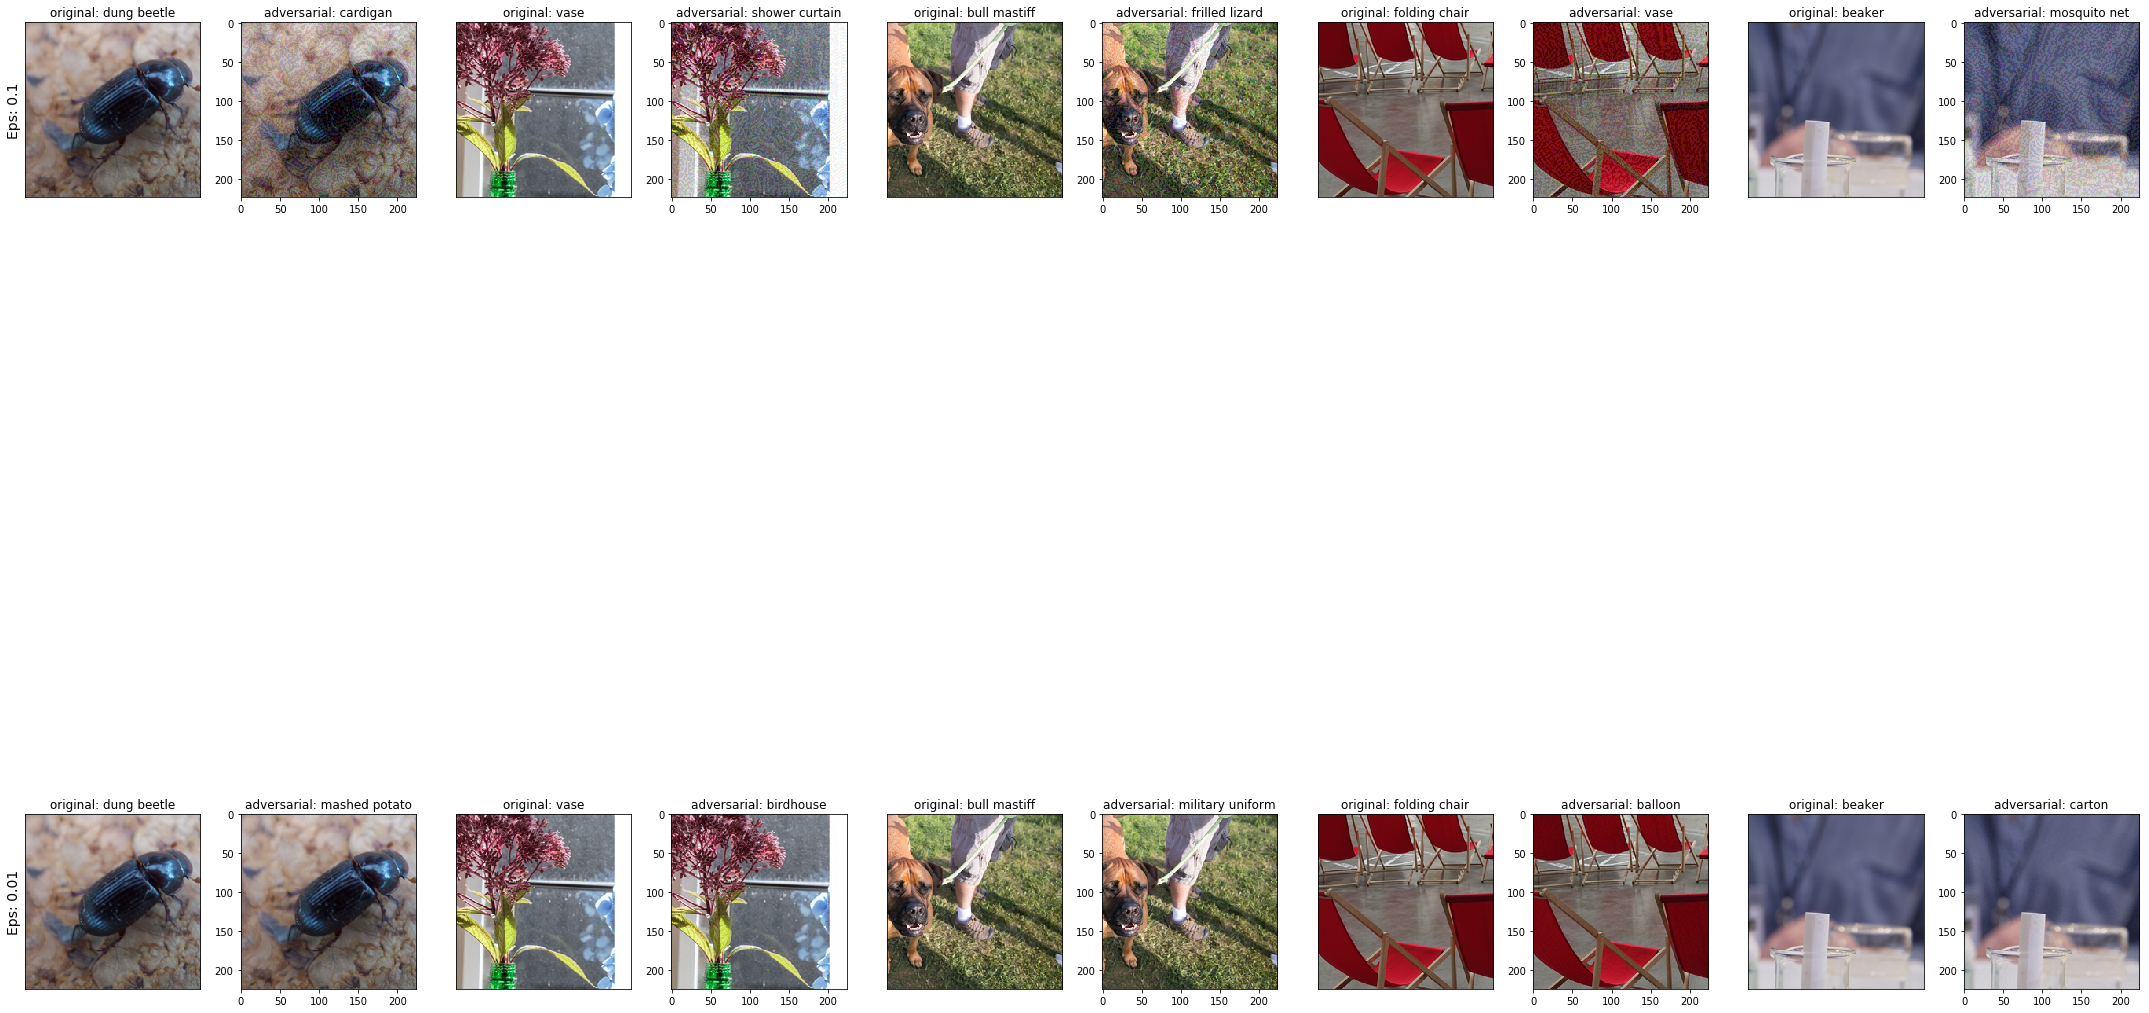

In [7]:
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,orig_img, ex = examples[i][j]
        plt.title("original: {}".format(label_name[orig][0].split(',')[0]))

        plt.imshow(orig_img/255.0)
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv][0].split(',')[0]))
        plt.imshow(ex/255.0)
plt.tight_layout()
plt.show()